## Getting started

You can find this notebook (and data) on [GitHub](https://github.com/exorad/GCMtools/tree/main/doc/source/notebooks).
We demonstrate the use of `GCMTools` on a set of data of HD209458b simulations from [Schneider et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220209183S/abstract).

import all needed packages

In [1]:
import matplotlib.pyplot as plt
from GCMtools import GCMT
from GCMtools import gcm_plotting as gcmp

This tutorial will showcase how to use the GCMT package to load and analyze `MITgcm` data (raw binary format).
Lets take a look at how easy it is to load data from a `MITgcm` run.

In [2]:
data = 'HD2_test/run'   # path to data
gcmt = GCMT(p_unit='bar', time_unit='day')  # create a GCMT object
gcmt.read_raw('MITgcm', data, iters="all", prefix=['T','U','V','W'], tag='HD2')

                              Welcome to GCMtools
[STAT] Set up GCMtools
   [INFO] pressure units: bar
   [INFO] time units: day
[STAT] Read in raw MITgcm data
   [INFO] Tag: HD2
   [INFO] File path: HD2_test/run
   [INFO] Iterations: 38016000, 41472000
time needed to build regridder: 1.1531109809875488
Regridder will use conservative method


We can also retrieve an xarray dataset from the GCMT object, for further use.

In [3]:
ds = gcmt['HD2']
# ds = gcmt.models # note this is equal, since we only loaded one dataset

Check the content of the dataset:

In [4]:
# ds

### Plot data

We now demonstrate how to do simple plots of the data.
We start with an isobaric slice of the temperature.

Don't forget to checkout the [options for the plotting functions](https://gcmtools.readthedocs.io/en/latest/usage.html#plotting).

[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 0.01
[STAT] Plot horizontal winds


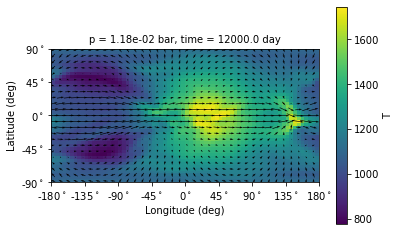

In [5]:
gcmt.isobaric_slice(p=1e-2, lookup_method='nearest', var_key='T', wind_kwargs={'windstream':False, 'sample_one_in':2})

Note that gcmt wraps the plot functions defined in GCMtools.gcm_plotting. You achieve the same with:

[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 0.01
[STAT] Plot horizontal winds


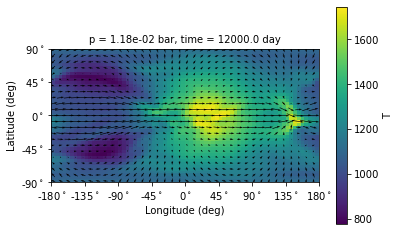

In [6]:
gcmp.isobaric_slice(ds, p=1e-2, lookup_method='nearest', var_key='T', wind_kwargs={'windstream':False, 'sample_one_in':2})

We can also do a zonal mean of the wind.

[STAT] Plot zonal mean
   [INFO] Variable to be plotted: U


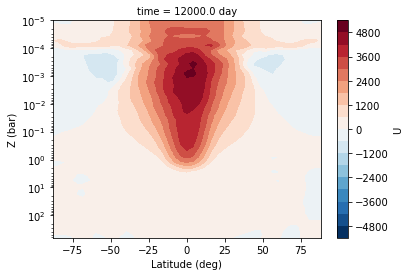

In [7]:
gcmt.zonal_mean('U', contourf = True, levels =20)

### Advanced plotting with cartopy

Plots look a lot nicer, if we use cartopy. So lets do it.

In [8]:
import cartopy.crs as ccrs
PROJECTION = ccrs.Robinson()

[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 0.001
[STAT] Plot horizontal winds
[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 0.1
[STAT] Plot horizontal winds
[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 0.01
[STAT] Plot horizontal winds
[STAT] Plot Isobaric slices
   [INFO] Variable to be plotted: T
   [INFO] Pressure level: 1
[STAT] Plot horizontal winds


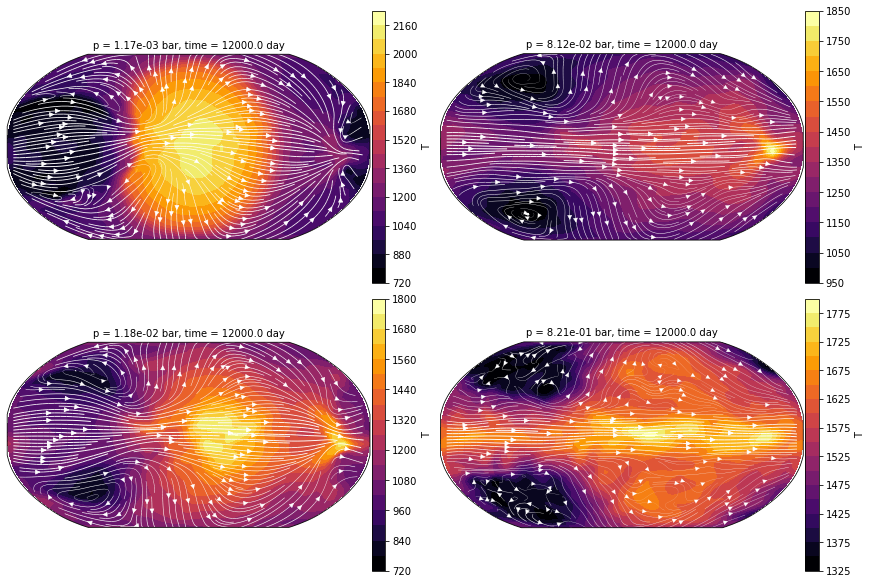

In [9]:
time = -1
fig, axes = plt.subplots(2,2,subplot_kw={'projection':PROJECTION}, figsize=(12,8), constrained_layout=True)
for i,Z in enumerate([1e-3, 1e-1,1e-2,1]):
    axt = axes.flat[i]
    gcmt.isobaric_slice(var_key='T',
                        ax=axt, p=Z, time=time, lookup_method ='nearest',
                        wind_kwargs={'transform':ccrs.PlateCarree(),'windstream':True, 'arrowColor':'w','sample_one_in':2},
                        transform=ccrs.PlateCarree(), cmap=plt.get_cmap('inferno'),
                        contourf=True, levels=20,
                        cbar_kwargs={'pad':.005})

Using cartopy is very simple. Make sure to create an axes obeject with the keyword `projection` to set to a cartopy projection.
You then use the `transform` keyword during plotting to set the coordinate system, that the data is defined in (`ccrs.PlateCarree()`)

### Postprocessing of data

#### Horizontal averages

We can do some additional post-processing, such as calculating global horizontal averages of the temperature

In [10]:
gcmt.add_horizontal_average('T', 'T_g', tag='HD2');

[STAT] Calculate horizontal average
   [INFO] Tag: HD2
   [INFO] Variable to be plotted: T
   [INFO] Output variable: T_g
   [INFO] Area of grid cells: area_c


Lets think about the temperature evolution of the horizontally averaged temperature profile.

[STAT] Plot horizontal winds
   [INFO] Variable to be plotted: T_g


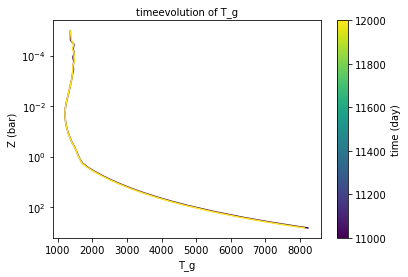

In [11]:
gcmt.time_evol('T_g')  # note that we only loaded two timesteps

#### Meridional overturning circulation

Calculate overturning circulation

In [12]:
gcmt.add_meridional_overturning(var_key_out='psi');

[STAT] Calculate meridional overturning streamfunction
   [INFO] Output variable: psi


[STAT] Plot zonal mean
   [INFO] Variable to be plotted: psi


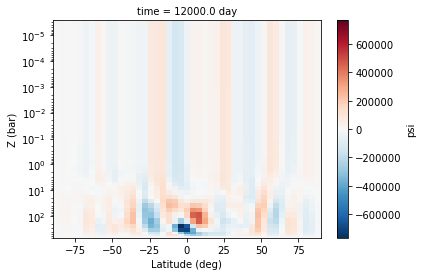

In [13]:
gcmt.zonal_mean('psi')

### Dealing with the GCMT object

GCMT binds in naturally into the pythonic environment. Here are a few examples of how you can interact with the GCMT object:

print the amount of loaded models:

In [14]:
len(gcmt)

1

check if a model is loaded:

In [15]:
bool(gcmt)

True

iterate over models:

In [16]:
for tag, ds in gcmt:
    print(tag, ds.Z.max().values)

HD2 650.0


Retrieve a model:

In [17]:
ds = gcmt.get('HD2')   # pythonic get (you can also set a default)
ds = gcmt.get_models('HD2')  # GCMT get, with more options
ds = gcmt.get_one_model('HD2')  # can raise an error if you want to
ds = gcmt['HD2']  # normal pythonic __getitem__

Set a model:

In [18]:
gcmt['HD2_clone'] = ds

You may want to check which of those is suited for your case. Just check the docs to find out:

In [19]:
help(gcmt.get_models)

Help on method get_models in module GCMtools.GCMtools:

get_models(tag=None, always_dict=False) method of GCMtools.GCMtools.GCMT instance
    Function return all GCMs in memory. If a tag is given, only return this
    one.
    
    Parameters
    ----------
    tag : str
        Name of the model that should be returned.
    always_dict: bool
        Force result to be a dictionary (if tag is None)
    
    Returns
    -------
    selected_models : GCMDatasetCollection or xarray Dataset
        All models in self._models, or only the one with the right tag.
        Will definetly be GCMDatasetCollection if always_dict=True

